In [29]:
import numpy as np
import re
import string
from collections import defaultdict
from random import shuffle, randint
import matplotlib.pyplot as plt

In [30]:
#comments = pd.read_csv("data/comments.csv")

In [31]:
# Preprocessing function: cleans and tokenizes text
def preprocess(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text.split()  # Split text into words

# Sample corpus of sentences (training data)
corpus_train = [
    "The quick brown fox jumps over the lazy dog",
    "I love natural language processing",
    "Word2Vec is a cool algorithm",
    "I enjoy learning new things"
]

# Sample validation dataset
corpus_val = [
    "Natural language processing is fun",
    "Learning new algorithms is enjoyable",
    "The lazy dog loves the quick brown fox"
]

# Preprocess the corpus: clean and tokenize each sentence
corpus_train = [preprocess(doc) for doc in corpus_train]
corpus_val = [preprocess(doc) for doc in corpus_val]

# Create a vocabulary: count occurrences of each word
vocab = defaultdict(int)
for sentence in corpus_train:
    for word in sentence:
        vocab[word] += 1

# Remove infrequent words from the vocabulary
min_count = 1
vocab = {word: count for word, count in vocab.items() if count >= min_count}

# Create word to index and index to word mappings
word_to_index = {word: idx for idx, (word, _) in enumerate(vocab.items())}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Initialize parameters
vocab_size = len(vocab)  # Number of unique words in the vocabulary
embedding_dim = 100  # Dimensionality of the word vectors
learning_rate = 0.01  # Learning rate for gradient descent
window_size = 2  # Context window size
neg_samples = 5  # Number of negative samples
dropout_rate = 0.3  # Dropout rate
patience = 3  # Early stopping patience

# Initialize weights: input-to-hidden and hidden-to-output
W1 = np.random.uniform(-0.8, 0.8, (vocab_size, embedding_dim))
W2 = np.random.uniform(-0.8, 0.8, (embedding_dim, vocab_size))

In [32]:
# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function to get negative samples for a given target word
def get_negative_samples(target, vocab_size, count):
    negatives = []
    while len(negatives) < count:
        neg = randint(0, vocab_size - 1)
        if neg != target:  # Ensure the negative sample is not the target word
            negatives.append(neg)
    return negatives

# Function to apply dropout
def apply_dropout(vec, rate):
    mask = np.random.binomial(1, 1 - rate, size=vec.shape)
    return vec * mask

In [33]:
# Function to calculate loss for a dataset
def calculate_loss(corpus, W1, W2, word_to_index, window_size, neg_samples):
    loss = 0
    for sentence in corpus:
        sentence_indices = [word_to_index[word] for word in sentence if word in word_to_index]
        for center_pos in range(len(sentence_indices)):
            center_word_idx = sentence_indices[center_pos]
            context_indices = list(range(max(0, center_pos - window_size), min(len(sentence_indices), center_pos + window_size + 1)))
            context_indices.remove(center_pos)
            
            for context_pos in context_indices:
                context_word_idx = sentence_indices[context_pos]
                negative_samples = get_negative_samples(center_word_idx, vocab_size, neg_samples)
                sample_indices = [context_word_idx] + negative_samples

                for sample_idx in sample_indices:
                    label = 1 if sample_idx == context_word_idx else 0
                    z = np.dot(W1[center_word_idx], W2[:, sample_idx])
                    prediction = sigmoid(z)
                    loss += -np.log(prediction) if label == 1 else -np.log(1 - prediction)
    return loss

Epoch 1, Train Loss: 395.6014703985328, Val Loss: 247.96056300466108
Epoch 2, Train Loss: 381.4349377576337, Val Loss: 226.84157005931797
Epoch 3, Train Loss: 384.54185490937306, Val Loss: 202.03907446649845
Epoch 4, Train Loss: 330.8456807001814, Val Loss: 181.03354546360134
Epoch 5, Train Loss: 334.53300194796736, Val Loss: 168.3513729011915
Epoch 6, Train Loss: 265.81739475256273, Val Loss: 170.505491225448
Epoch 7, Train Loss: 269.4917029452602, Val Loss: 150.96456262874833
Epoch 8, Train Loss: 268.7858021440645, Val Loss: 149.9342794528486
Epoch 9, Train Loss: 241.74274535385695, Val Loss: 166.2200743700425
Epoch 10, Train Loss: 251.8018711557443, Val Loss: 144.60309106226458
Epoch 11, Train Loss: 211.87336341637328, Val Loss: 122.56873825563237
Epoch 12, Train Loss: 212.6674263637528, Val Loss: 136.68528416396245
Epoch 13, Train Loss: 207.50360130902803, Val Loss: 134.42668656636076
Epoch 14, Train Loss: 218.18084422398155, Val Loss: 129.40015200540765
Early stopping at epoch 14


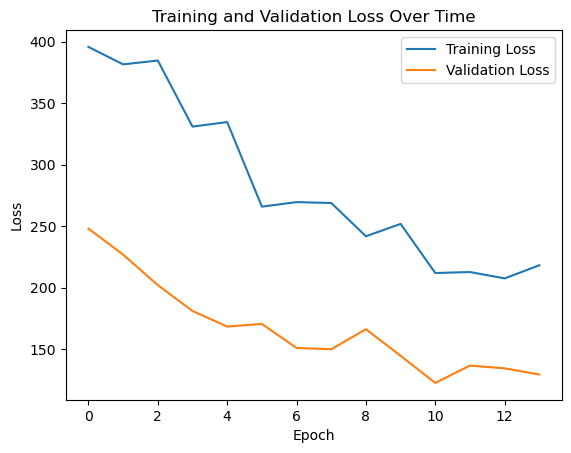

In [34]:
# Training function for the Word2Vec model with early stopping and dropout
def train_word2vec(corpus_train, corpus_val, word_to_index, index_to_word, W1, W2, learning_rate, window_size, neg_samples, dropout_rate, patience, epochs=50):
    vocab_size = len(word_to_index)
    train_loss_history = []  # List to store training loss at each epoch
    val_loss_history = []  # List to store validation loss at each epoch
    best_val_loss = float('inf')  # Initialize best validation loss
    no_improvement_epochs = 0  # Count epochs with no improvement
    
    for epoch in range(epochs):
        shuffle(corpus_train)  # Shuffle the corpus at the beginning of each epoch
        train_loss = 0  # Initialize training loss for the epoch
        
        for sentence in corpus_train:
            sentence_indices = [word_to_index[word] for word in sentence if word in word_to_index]
            for center_pos in range(len(sentence_indices)):
                center_word_idx = sentence_indices[center_pos]
                context_indices = list(range(max(0, center_pos - window_size), min(len(sentence_indices), center_pos + window_size + 1)))
                context_indices.remove(center_pos)
                
                for context_pos in context_indices:
                    context_word_idx = sentence_indices[context_pos]
                    negative_samples = get_negative_samples(center_word_idx, vocab_size, neg_samples)
                    sample_indices = [context_word_idx] + negative_samples

                    for sample_idx in sample_indices:
                        label = 1 if sample_idx == context_word_idx else 0
                        z = np.dot(W1[center_word_idx], W2[:, sample_idx])
                        z = apply_dropout(z, dropout_rate)  # Apply dropout
                        prediction = sigmoid(z)
                        error = label - prediction
                        train_loss += -np.log(prediction) if label == 1 else -np.log(1 - prediction)

                        # Gradient update for weights
                        W1[center_word_idx] += learning_rate * error * W2[:, sample_idx]
                        W2[:, sample_idx] += learning_rate * error * W1[center_word_idx]

        train_loss_history.append(train_loss)  # Append training loss for the current epoch
        val_loss = calculate_loss(corpus_val, W1, W2, word_to_index, window_size, neg_samples)
        val_loss_history.append(val_loss)  # Append validation loss for the current epoch
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
    
    return train_loss_history, val_loss_history

# Train the Word2Vec model with early stopping and dropout, and get the loss history
train_loss_history, val_loss_history = train_word2vec(corpus_train, corpus_val, word_to_index, index_to_word, W1, W2, learning_rate, window_size, neg_samples, dropout_rate, patience, epochs=100)

# Plot the loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [35]:
# Get the word vector for a specific word
def get_word_vector(word):
    return W1[word_to_index[word]]

# Test the word vector retrieval
word = "love"
print(f"Vector for '{word}': {get_word_vector(word)}")

Vector for 'love': [ 0.32967642  0.20962584 -0.19999234  0.50746454 -0.36895608  0.56973287
 -0.46194968 -0.23281486 -0.07418715  0.04077017  0.52202598  0.08918705
  0.72039143 -0.35664342 -0.39387216  0.78018162 -0.41540798  0.11002259
 -0.80068919  0.68296547 -0.35265098 -0.73629822  0.48870112  0.41729333
  0.57746912  0.05634591 -0.67157719  0.30858189  0.35732776  0.30165978
  0.55094717  0.2157749   0.21713246  0.34449331 -0.65459133  0.64912084
 -0.01911289  0.30888308 -0.21792916 -0.3106169  -0.31569687  0.01967885
 -0.84389507 -0.727317   -0.56332271 -0.17525195  0.12464249 -0.15059182
 -0.67299858  0.69055936 -0.34205184  0.19363645 -0.40013541 -0.1302929
 -0.72010926 -0.4204297  -0.17319406 -0.78521319  0.24166465 -0.4359429
 -0.51811008  0.14873075  0.39492503 -0.19526978  0.30324878  0.25534403
 -0.14140323 -0.54894935 -0.18607595 -0.23945178 -0.20192939 -0.63649034
 -0.61284265 -0.65769112 -0.17445822 -0.09196754 -0.4425369   0.44645479
 -0.57548338  0.39394191  0.201517

In [36]:
# Function to find similar words to a given word
def find_similar_words(word, top_n=5):
    word_vector = get_word_vector(word)
    similarities = {}
    for other_word in word_to_index:
        if other_word == word:
            continue
        other_word_vector = get_word_vector(other_word)
        # Cosine similarity between word vectors
        similarity = np.dot(word_vector, other_word_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(other_word_vector))
        similarities[other_word] = similarity
    # Sort words by similarity and return the top_n most similar words
    similar_words = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return similar_words[:top_n]

# Find and print similar words to "love"
similar_words = find_similar_words("love")
print(f"Words similar to 'love': {similar_words}")

Words similar to 'love': [('learning', 0.26791816655337114), ('cool', 0.20000573087514323), ('brown', 0.16993345921666628), ('fox', 0.12007165035471216), ('processing', 0.1160159784002131)]
